In [1]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import h5py
from tqdm import tqdm
from pyeit.mesh import create, shape
from pyeit.mesh.wrapper import PyEITAnomaly, PyEITAnomaly_Circle, set_perm
from pyeit.eit.fem import EITForward
from pyeit.eit import protocol
import pyeit.eit.interp2d as interp2d_module
from abc import ABC
from pyeit.eit.greit import GREIT


class PyEITAnomaly_Irregular(PyEITAnomaly):
    

    def __init__(self, center, base_radius, perm, irregularity=0.3, n_circles=None):
        super().__init__(center, perm)
        self.base_radius = base_radius
        self.irregularity = irregularity

        if n_circles is None:
            n_circles = np.random.randint(3, 7)

        self.sub_circles = []
        for i in range(n_circles):
            angle = 2 * np.pi * i / n_circles + np.random.uniform(-0.3, 0.3)
            offset_mag = base_radius * irregularity * np.random.uniform(0.3, 1.0)
            offset = np.array([offset_mag * np.cos(angle), offset_mag * np.sin(angle)])
            r = base_radius * np.random.uniform(0.5, 1.3)
            self.sub_circles.append({
                'center': center + offset,
                'radius': r
            })

    def mask(self, pts):
        pts = pts[:, :2].reshape((-1, 2))
        combined_mask = np.zeros(len(pts), dtype=bool)
        for circ in self.sub_circles:
            dist = np.sqrt(np.sum((pts - circ['center'])**2, axis=1))
            combined_mask |= (dist < circ['radius'])
        return combined_mask


class BrainEITDatasetGenerator:
    

    def __init__(self, n_el=16, h0_range=(0.04, 0.06), frequency=10000, grid_size=128):
        self.n_el = n_el
        self.h0_range = h0_range
        self.frequency = frequency
        self.omega = 2 * np.pi * frequency
        self.grid_size = grid_size

        self.protocol_configs = [
            {'dist_exc': 1, 'step_meas': 1, 'name': 'adjacent'},
            {'dist_exc': 8, 'step_meas': 1, 'name': 'opposite'},
            {'dist_exc': 1, 'step_meas': 2, 'name': 'skip1'},
            {'dist_exc': 2, 'step_meas': 1, 'name': 'skip2'},
        ]

        self.tissues = {
            'gray_matter': {
                'sigma_mean': 0.45,
                'sigma_std': 0.05,
                'epsilon': 5e5 * 8.854e-12,
                'radius_range': (0, 0.5)
            },
            'white_matter': {
                'sigma_mean': 0.25,
                'sigma_std': 0.03,
                'epsilon': 3e5 * 8.854e-12,
                'radius_range': (0.5, 0.7)
            },
            'csf_skull': {
                'sigma_mean': 1.65,
                'sigma_std': 0.15,
                'epsilon': 1e5 * 8.854e-12,
                'radius_range': (0.7, 1.0)
            }
        }

        self.anomaly_types = {
            'ischemic': {
                'sigma_mean': 0.15,
                'sigma_range': (0.10, 0.20),
                'epsilon': 2e5 * 8.854e-12,
                'size_range': (0.05, 0.25),
                'irregularity': 0.3,
                'description': 'Reduced blood flow'
            },
            'hemorrhagic': {
                'sigma_mean': 0.85,
                'sigma_range': (0.60, 1.20),
                'epsilon': 8e5 * 8.854e-12,
                'size_range': (0.08, 0.20),
                'irregularity': 0.35,
                'description': 'Bleeding'
            },
            'edema': {
                'sigma_mean': 0.70,
                'sigma_range': (0.60, 0.80),
                'epsilon': 6e5 * 8.854e-12,
                'size_range': (0.10, 0.30),
                'irregularity': 0.25,
                'description': 'Brain swelling'
            },
            'tumor_glioma': {
                'sigma_mean': 0.25,
                'sigma_range': (0.20, 0.30),
                'epsilon': 4e5 * 8.854e-12,
                'size_range': (0.08, 0.35),
                'irregularity': 0.45,
                'description': 'Glioma tumor'
            },
            'tumor_meningioma': {
                'sigma_mean': 0.45,
                'sigma_range': (0.40, 0.50),
                'epsilon': 5e5 * 8.854e-12,
                'size_range': (0.05, 0.20),
                'irregularity': 0.30,
                'description': 'Meningioma tumor'
            }
        }
        import pickle
        try:
            with open('mesh_pool.pkl', 'rb') as f:
                self.mesh_pool = pickle.load(f)
            print(f"Loaded cached mesh pool with {len(self.mesh_pool)} variants")
        except FileNotFoundError:
            print("Pre-generating mesh pool...")
            self.mesh_pool = [self.create_mesh_variant() for _ in range(100)]
            print(f"Mesh pool ready with {len(self.mesh_pool)} variants")
            # Automatically save for future use
            with open('mesh_pool.pkl', 'wb') as f:
                pickle.dump(self.mesh_pool, f)
            print("Mesh pool saved to mesh_pool.pkl")

    def create_mesh_variant(self):
        
        h0 = np.random.uniform(*self.h0_range)
        scale = np.random.uniform(0.85, 1.15)
        x_scale = scale * np.random.uniform(0.95, 1.05)
        y_scale = scale * np.random.uniform(0.95, 1.05)

        def scaled_head(pts):
            pts_scaled = pts.copy()
            pts_scaled[:, 0] /= x_scale
            pts_scaled[:, 1] /= y_scale
            return shape.head_symm(pts_scaled) * scale

        mesh = create(n_el=self.n_el, fd=scaled_head, h0=h0)
        return mesh, x_scale, y_scale

    def create_background_perm(self, mesh):
        
        elem_centers = mesh.elem_centers
        r_centers = np.sqrt(elem_centers[:, 0]**2 + elem_centers[:, 1]**2)
        theta = np.arctan2(elem_centers[:, 1], elem_centers[:, 0])

        background_perm = np.ones(mesh.n_elems, dtype=complex)

        n_folds = np.random.randint(4, 8)
        angular_variation = 0.05 * np.sin(n_folds * theta)

        for tissue_name, props in self.tissues.items():
            perm_base = props['sigma_mean'] + 1j * self.omega * props['epsilon']
            r_min, r_max = props['radius_range']
            mask = (r_centers >= r_min) & (r_centers < r_max)

            n_elements = np.sum(mask)
            tissue_variation = np.random.normal(1.0, props['sigma_std']/props['sigma_mean'], n_elements)
            tissue_variation = np.clip(tissue_variation, 0.7, 1.3)

            perm_values = perm_base * tissue_variation * (1 + angular_variation[mask])
            background_perm[mask] = perm_values

        return background_perm

    def generate_anomaly(self, anomaly_type, mesh, center=None, radius=None, irregular=True):
        
        if center is None:
            angle = np.random.uniform(0, 2*np.pi)
            r = np.random.uniform(0.15, 0.55)
            center = np.array([r * np.cos(angle), r * np.sin(angle)])

        props = self.anomaly_types[anomaly_type]

        if radius is None:
            radius = np.random.uniform(*props['size_range'])

        sigma = np.random.uniform(*props['sigma_range'])
        perm = sigma + 1j * self.omega * props['epsilon']

        force_irregular = anomaly_type in ['tumor_glioma', 'tumor_meningioma', 'edema']

        if (irregular and np.random.random() > 0.3) or force_irregular:
            return PyEITAnomaly_Irregular(
                center=center,
                base_radius=radius,
                perm=perm,
                irregularity=props['irregularity']
            )
        else:
            return PyEITAnomaly_Circle(center=center, r=radius, perm=perm)

    def generate_ground_truth_image(self, mesh, perm, grid_size=128):
        
        from pyeit.eit.greit import GREIT

        temp_protocol = protocol.create(self.n_el, dist_exc=1, step_meas=1, parser_meas='std')
        temp_greit = GREIT(mesh, temp_protocol)
        temp_greit.setup(n=grid_size)

        xg, yg, mask = temp_greit.xg, temp_greit.yg, temp_greit.mask
        xy = mesh.elem_centers
        xyi = np.vstack((xg.flatten(), yg.flatten())).T

        d_mat = np.subtract.outer(xy[:, 0], xyi[:, 0])**2 + np.subtract.outer(xy[:, 1], xyi[:, 1])**2
        d_mat = np.sqrt(d_mat)
        d_max = np.max(d_mat)
        d_mat = 5.0 * d_mat / d_max
        r0 = 5.0 * 0.05
        weight = 1.0 / (1 + np.exp(20.0 * (d_mat - r0)))
        w_mat = weight / weight.sum(axis=0)

        im = np.dot(w_mat.T, np.real(perm))
        im[mask] = 0.0
        im = im.reshape(xg.shape)

        return im, xg, yg
      


    def generate_sample(self, num_anomalies=1, anomaly_config=None, noise_level='medium'):
        
        mesh_idx = np.random.randint(len(self.mesh_pool))  
        mesh, x_scale, y_scale = self.mesh_pool[mesh_idx]


        protocol_config = self.protocol_configs[np.random.randint(len(self.protocol_configs))]


        protocol_obj = protocol.create(
            n_el=self.n_el,
            dist_exc=protocol_config['dist_exc'],
            step_meas=protocol_config['step_meas'],
            parser_meas='std'
        )

        fwd = EITForward(mesh, protocol_obj)
        background_perm = self.create_background_perm(mesh)

        anomalies = []
        anomaly_info = []

        if anomaly_config is None:
            for _ in range(num_anomalies):
                anomaly_type = np.random.choice(
                    list(self.anomaly_types.keys()),
                    p=[0.35, 0.25, 0.20, 0.12, 0.08]
                )
                anomaly = self.generate_anomaly(anomaly_type, mesh)
                anomalies.append(anomaly)
                anomaly_info.append({
                    'type': anomaly_type,
                    'center': anomaly.center.tolist(),
                    'radius': getattr(anomaly, 'r', getattr(anomaly, 'base_radius', None)),
                    'perm': complex(anomaly.perm),
                    'irregular': isinstance(anomaly, PyEITAnomaly_Irregular)
                })
        else:
            for config in anomaly_config:
                anomaly = self.generate_anomaly(mesh=mesh, **config)
                anomalies.append(anomaly)
                anomaly_info.append({**config, 'perm': complex(anomaly.perm)})

        mesh.perm = background_perm
        if anomalies:
            mesh_with_anomalies = set_perm(mesh, anomaly=anomalies, background=None)
        else:
            mesh_with_anomalies = mesh

        v0 = fwd.solve_eit(perm=background_perm)
        v1 = fwd.solve_eit(perm=mesh_with_anomalies.perm)

        v0_noisy, v1_noisy = self.add_noise(v0, v1, noise_level)

        gt_baseline, xg, yg = self.generate_ground_truth_image(mesh, background_perm)
        gt_anomaly, _, _ = self.generate_ground_truth_image(mesh, mesh_with_anomalies.perm)

        return {
            'v_baseline': v0_noisy,
            'v_anomaly': v1_noisy,
            'v_baseline_clean': v0,
            'v_anomaly_clean': v1,
            'difference': v1_noisy - v0_noisy,
            'gt_baseline': gt_baseline,
            'gt_anomaly': gt_anomaly,
            'gt_difference': gt_anomaly - gt_baseline,
            'anomaly_info': anomaly_info,
            'num_anomalies': num_anomalies,
            'protocol': protocol_config['name'],
            'mesh_scale': {'x': x_scale, 'y': y_scale},
            'noise_level': noise_level
        }

    def add_noise(self, v0, v1, noise_level='medium'):
        
        noise_levels = {
            'low': {'snr_db': 70, 'contact': 0.005, 'motion': 0.002, 'drift': 0.001},
            'medium': {'snr_db': 60, 'contact': 0.01, 'motion': 0.005, 'drift': 0.003},
            'high': {'snr_db': 50, 'contact': 0.02, 'motion': 0.01, 'drift': 0.005}
        }

        params = noise_levels[noise_level]
        rng = np.random.default_rng()

        # Thermal/Johnson noise
        signal_power = np.mean(np.abs(v1)**2)
        noise_power = signal_power / (10**(params['snr_db']/10))
        thermal = rng.normal(0, np.sqrt(noise_power), v1.shape) + \
                  1j * rng.normal(0, np.sqrt(noise_power), v1.shape)

        # Contact impedance variation
        
        contact_impedances = rng.normal(1.0, params['contact'], self.n_el)  
        n_meas_per_exc = len(v1) // self.n_el  
        contact_base = np.repeat(contact_impedances, n_meas_per_exc)[:len(v1)] * np.abs(v1)  
        contact_noise = rng.normal(0, 1, v1.shape) + 1j * rng.normal(0, 1, v1.shape)  
        contact = contact_base * contact_noise

        # Motion artifacts (low frequency drift)
        motion = params['motion'] * np.abs(v1) * \
                 np.sin(2*np.pi*np.arange(len(v1))/len(v1))

        # Baseline drift
        drift = params['drift'] * np.abs(v1) * \
                (np.arange(len(v1)) / len(v1))

        # Combine all noise sources
        v0_noisy = v0 + thermal + contact + motion + drift
        v1_noisy = v1 + thermal + contact + motion + drift

        return v0_noisy, v1_noisy

    def generate_dataset(self, n_samples=1000, output_dir='brain_eit_dataset', save_format='hdf5'):
        
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True, parents=True)

        print(f"\nGenerating {n_samples} samples...")

        if save_format == 'hdf5':
            self._generate_hdf5_dataset(n_samples, output_path)
        else:
            self._generate_numpy_dataset(n_samples, output_path)

    def _generate_hdf5_dataset(self, n_samples, output_path):

        

        # Generate the first sample to determine max_measurements and img_shape
        first_sample = self.generate_sample()
        max_measurements = len(first_sample['v_baseline'])
        img_shape = first_sample['gt_baseline'].shape


        with h5py.File(output_path / 'brain_eit_dataset.h5', 'w') as f:
            # Create variable-length datasets for voltage data
            vlen_complex = h5py.vlen_dtype(complex)
            ds_v_baseline = f.create_dataset('v_baseline', (n_samples,), dtype=vlen_complex)
            ds_v_anomaly = f.create_dataset('v_anomaly', (n_samples,), dtype=vlen_complex)
            ds_difference = f.create_dataset('difference', (n_samples,), dtype=vlen_complex)

            # Create fixed-size datasets for image data
            ds_gt_baseline = f.create_dataset('gt_baseline', (n_samples, *img_shape), dtype=float)
            ds_gt_anomaly = f.create_dataset('gt_anomaly', (n_samples, *img_shape), dtype=float)
            ds_gt_diff = f.create_dataset('gt_difference', (n_samples, *img_shape), dtype=float)

            metadata = []

            # Generate and store samples
            for i in tqdm(range(n_samples), desc="Generating samples"):
                num_anomalies = np.random.choice([0, 1, 2], p=[0.2, 0.6, 0.2])
                noise_level = np.random.choice(['low', 'medium', 'high'])

                sample = self.generate_sample(
                    num_anomalies=num_anomalies,
                    noise_level=noise_level
                )

                
                ds_v_baseline[i] = sample['v_baseline']
                ds_v_anomaly[i] = sample['v_anomaly']
                ds_difference[i] = sample['difference']
                ds_gt_baseline[i] = sample['gt_baseline']
                ds_gt_anomaly[i] = sample['gt_anomaly']
                ds_gt_diff[i] = sample['gt_difference']

                metadata_entry = {
                    'sample_id': int(i), 
                    'num_anomalies': int(sample['num_anomalies']), 
                    'anomaly_info': sample['anomaly_info'],
                    'noise_level': noise_level,
                    'protocol': sample['protocol'],
                    'n_measurements': int(len(sample['v_baseline'])) 
                }

                # Convert complex numbers in anomaly_info to strings for JSON serialization
                for anomaly in metadata_entry['anomaly_info']:
                    if 'perm' in anomaly and isinstance(anomaly['perm'], complex):
                        anomaly['perm'] = str(anomaly['perm'])

                metadata.append(metadata_entry)

            # Save metadata
            f.attrs['metadata'] = json.dumps(metadata)
            f.attrs['n_el'] = self.n_el
            f.attrs['frequency'] = self.frequency
            f.attrs['max_measurements'] = max_measurements


        print(f"\nDataset saved to {output_path / 'brain_eit_dataset.h5'}")
        print(f"Size: {n_samples} samples, with variable number of measurements")



    def _generate_numpy_dataset(self, n_samples, output_path):

        all_samples = {
            'v_baseline': [],
            'v_anomaly': [],
            'difference': [],
            'gt_baseline': [],
            'gt_anomaly': [],
            'gt_difference': [],
            'metadata': []
        }

        for i in tqdm(range(n_samples)):
            num_anomalies = np.random.choice([0, 1, 2], p=[0.2, 0.6, 0.2])
            noise_level = np.random.choice(['low', 'medium', 'high'])

            sample = self.generate_sample(
                num_anomalies=num_anomalies,
                noise_level=noise_level
            )

            all_samples['v_baseline'].append(sample['v_baseline'])
            all_samples['v_anomaly'].append(sample['v_anomaly'])
            all_samples['difference'].append(sample['difference'])
            all_samples['gt_baseline'].append(sample['gt_baseline'])
            all_samples['gt_anomaly'].append(sample['gt_anomaly'])
            all_samples['gt_difference'].append(sample['gt_difference'])
            metadata_entry = {
                'sample_id': int(i), 
                'num_anomalies': int(sample['num_anomalies']), 
                'anomaly_info': sample['anomaly_info'],
                'noise_level': noise_level,
                'protocol': sample['protocol']
            }

            # Convert complex numbers in anomaly_info to strings for JSON serialization
            for anomaly in metadata_entry['anomaly_info']:
                if 'perm' in anomaly and isinstance(anomaly['perm'], complex):
                    anomaly['perm'] = str(anomaly['perm'])

            all_samples['metadata'].append(metadata_entry)


        
        for key in ['v_baseline', 'v_anomaly', 'difference', 'gt_baseline', 'gt_anomaly', 'gt_difference']:
            all_samples[key] = np.array(all_samples[key], dtype=object)

    
        np.savez_compressed(
            output_path / 'brain_eit_dataset.npz',
            **{k: v for k, v in all_samples.items() if k != 'metadata'}
        )

        with open(output_path / 'metadata.json', 'w') as f:
            json.dump(all_samples['metadata'], f, indent=2)

        print(f"\nDataset saved to {output_path}")



if __name__ == '__main__':
    # Initialize generator
    generator = BrainEITDatasetGenerator(n_el=16, h0_range=(0.04, 0.06))

    
    generator.generate_dataset(
        n_samples=1000,
        output_dir='brain_eit_training_batch_6',
        save_format='hdf5'
    )

     
    generator.generate_dataset(
        n_samples=500,
        output_dir='brain_eit_validation_batch_2',
        save_format='hdf5'
    )

     
    generator.generate_dataset(
        n_samples=500,
        output_dir='brain_eit_test_batch_1',
        save_format='hdf5'
    )

    print("\n Dataset generation complete!")
    print("\nDataset structure:")
    print("\nEach sample contains:")
    print("  - Voltage measurements (baseline and with anomalies)")
    print("  - Ground truth conductivity images")
    print("  - Difference measurements")
    print("  - Anomaly metadata (type, location, size)")

Loaded cached mesh pool with 100 variants

Generating 1000 samples...


Generating samples: 100%|██████████| 1000/1000 [1:51:18<00:00,  6.68s/it]


Dataset saved to brain_eit_training_batch_6\brain_eit_dataset.h5
Size: 1000 samples, with variable number of measurements

✓ Dataset generation complete!

Dataset structure:
  - Training: 50,000 samples
  - Validation: 10,000 samples
  - Test: 5,000 samples

Each sample contains:
  - Voltage measurements (baseline and with anomalies)
  - Ground truth conductivity images
  - Difference measurements
  - Anomaly metadata (type, location, size)


In [2]:
import pickle  
  
# Save the mesh pool to disk  
with open('mesh_pool.pkl', 'wb') as f:  
    pickle.dump(generator.mesh_pool, f)  
print("Mesh pool saved to mesh_pool.pkl")

Mesh pool saved to mesh_pool.pkl


Dataset keys: ['difference', 'gt_anomaly', 'gt_baseline', 'gt_difference', 'v_anomaly', 'v_baseline']

Dataset shapes:
  difference: (1000,)
  gt_anomaly: (1000, 128, 128)
  gt_baseline: (1000, 128, 128)
  gt_difference: (1000, 128, 128)
  v_anomaly: (1000,)
  v_baseline: (1000,)

First sample metadata:
  Number of anomalies: 1
  Protocol: adjacent
  Noise level: high
  Anomaly types: ['ischemic']


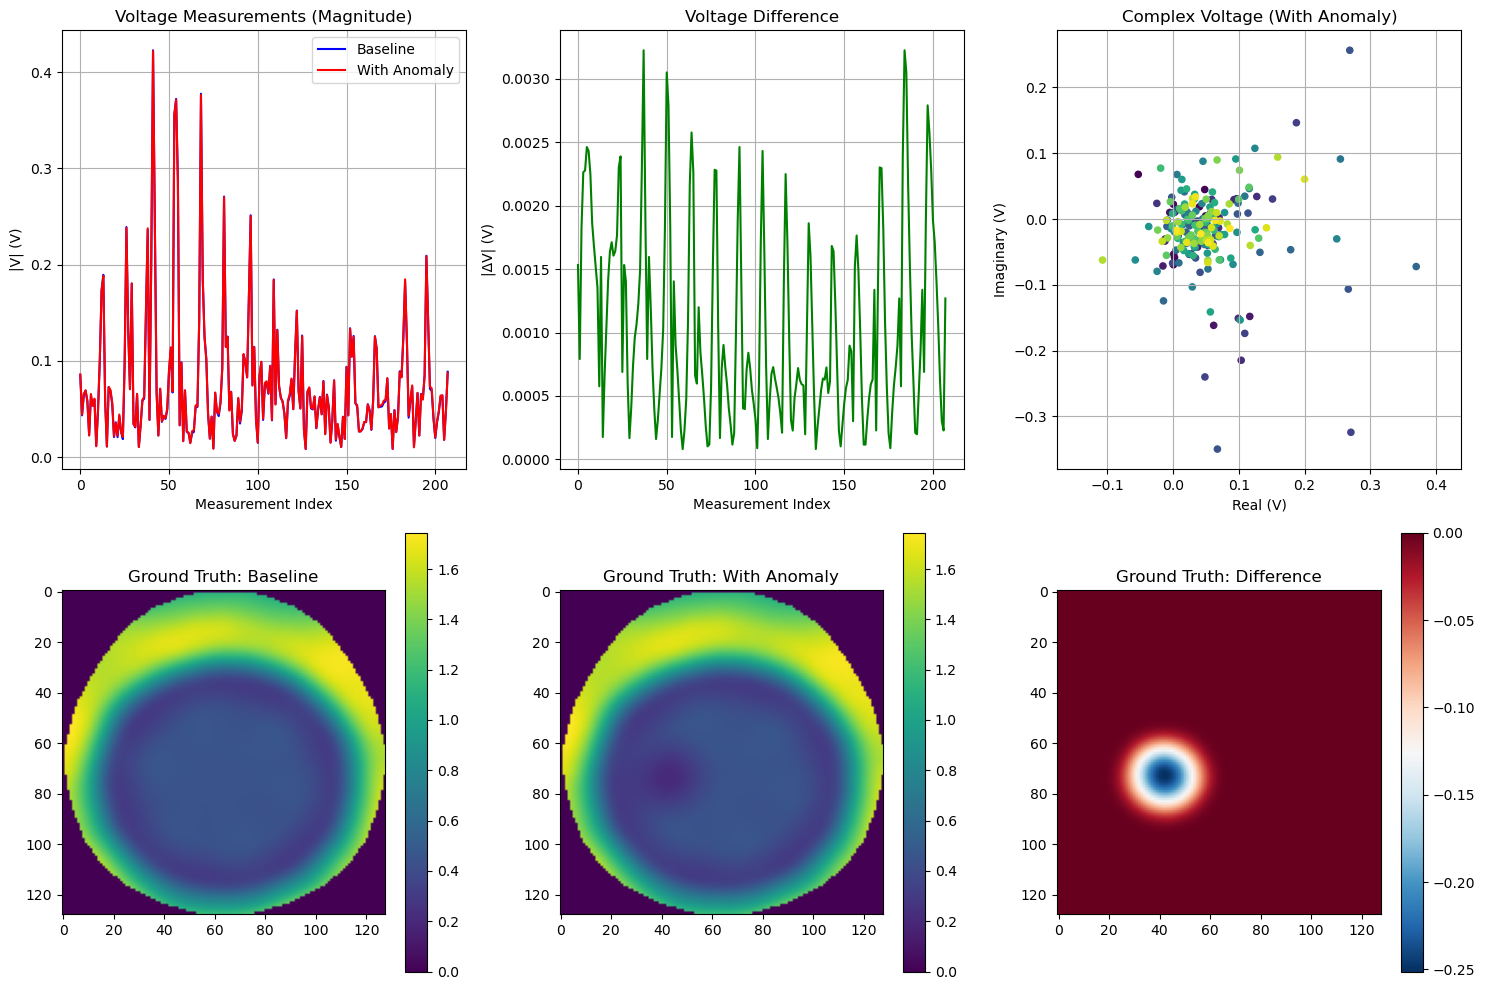

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the training dataset
with h5py.File('brain_eit_training_batch_6/brain_eit_dataset.h5', 'r') as f:
    print("Dataset keys:", list(f.keys()))
    print("\nDataset shapes:")
    for key in f.keys():
        print(f"  {key}: {f[key].shape}")

    # Load first sample
    v_baseline = f['v_baseline'][0]
    v_anomaly = f['v_anomaly'][0]
    gt_baseline = f['gt_baseline'][0]
    gt_anomaly = f['gt_anomaly'][0]
    gt_difference = f['gt_difference'][0]

    # Load metadata
    import json
    metadata = json.loads(f.attrs['metadata'])
    print("\nFirst sample metadata:")
    print(f"  Number of anomalies: {metadata[0]['num_anomalies']}")
    print(f"  Protocol: {metadata[0]['protocol']}")
    print(f"  Noise level: {metadata[0]['noise_level']}")
    print(f"  Anomaly types: {[info['type'] for info in metadata[0]['anomaly_info']]}")

# Visualize the results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot voltage measurements
axes[0, 0].plot(np.abs(v_baseline), 'b-', label='Baseline')
axes[0, 0].plot(np.abs(v_anomaly), 'r-', label='With Anomaly')
axes[0, 0].set_title('Voltage Measurements (Magnitude)')
axes[0, 0].set_xlabel('Measurement Index')
axes[0, 0].set_ylabel('|V| (V)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot difference measurements
axes[0, 1].plot(np.abs(v_anomaly - v_baseline), 'g-')
axes[0, 1].set_title('Voltage Difference')
axes[0, 1].set_xlabel('Measurement Index')
axes[0, 1].set_ylabel('|ΔV| (V)')
axes[0, 1].grid(True)

# Plot complex plane
axes[0, 2].scatter(np.real(v_anomaly), np.imag(v_anomaly), c=np.arange(len(v_anomaly)), cmap='viridis', s=20)
axes[0, 2].set_title('Complex Voltage (With Anomaly)')
axes[0, 2].set_xlabel('Real (V)')
axes[0, 2].set_ylabel('Imaginary (V)')
axes[0, 2].grid(True)
axes[0, 2].axis('equal')

# Plot ground truth images
im1 = axes[1, 0].imshow(gt_baseline, cmap='viridis')
axes[1, 0].set_title('Ground Truth: Baseline')
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(gt_anomaly, cmap='viridis')
axes[1, 1].set_title('Ground Truth: With Anomaly')
plt.colorbar(im2, ax=axes[1, 1])

im3 = axes[1, 2].imshow(gt_difference, cmap='RdBu_r')
axes[1, 2].set_title('Ground Truth: Difference')
plt.colorbar(im3, ax=axes[1, 2])

plt.tight_layout()
plt.savefig('dataset_visualization.png', dpi=150)
plt.show()